# OBESITY RISK PREDICTION USING MULTI CLASS CLASSIFICATION

This notebook is based on IBM Skills Network Machine Learning with Python course. In this notebook, we will go through different strategies of multi-class classification and implement the same on 'Obesity risk prediction' dataset. We will understand the use of one-hot encoding for categorical variables, implement logistic regression for multi class classification using One-vs-All (OvA) and One-vs-One (OvO) strategies and, evaluate model performance using appropriate metrics.

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## About the dataset

The dataset being used is the 'Obesity Risk Prediction' dataset publicly available on [UCI Library](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition) under the [CCA 4.0](https://creativecommons.org/licenses/by/4.0/legalcode) license. The dataset has 17 attributes in total along with 2111 samples.

The attributes of the dataset are described below:

| Variable Name | Type | Description |
|----------------|--------|------------|
|Gender|Categorical|
|Age|Continuous|
|Height|Continuous|
|Weight|Continuous|
|family_history_with_overweight|Binary|Has a family member suffered or suffers from overweight?|
|FAVC| Binary | Do you eat high caloric food frequently?|
|FCVC| Integer| Do you usually eat vegetables in your meals?|
|NCP|Continuous|How many main meals do you have daily?|
|CAEC|Categorical|Do you eat any food between meals?|
|Smoke|Binary|Do you smoke?|
|CH20|Continuous|How much water do you drink daily?|
|SCC| Binary|Do you monitor the calories you eat daily?|
|FAF|Continuous|How often do you have physical activity?|
|TUE|Integer|How much time do you use technological devices such as cell phone, videogames, television, computer and others?|
|CALC|Categorical|How often do you drink alcohol?|
|MTRANS|Categorical|Which transportation do you usually use?|
|NObeyesdad|Categorical|Obesity level|


## Load the dataset

In [2]:
url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv'
df = pd.read_csv(url)
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


## Exploratory Data Analysis

Lets visualize the distribution of the target variable to understand the class balance.

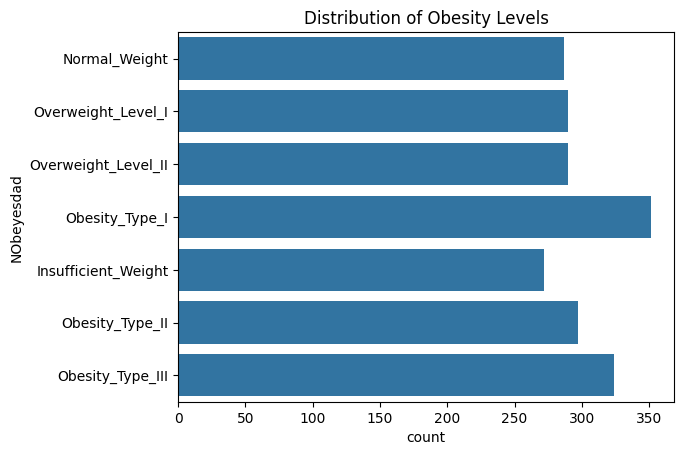

In [3]:
# Distribution of target variable
sns.countplot(data=df,y='NObeyesdad')
plt.title('Distribution of Obesity Levels')
plt.show()

The above plot shows that the dataset is fairly balanced and does not require any special attention in terms of biased training.

Lets now check for null values and display a summary of the dataset using .info() and .describe() methods.

In [4]:
print(df.isnull().sum())
print(df.info())
print(df.describe())

Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height             

## Preprocessing the data

### Feature Scaling

Scale the numerical features to standardize their ranges for better model performance.

In [5]:
# standardizing continuous numerical features

cont_cols = df.select_dtypes(include=['float64']).columns.to_list()

scaler = StandardScaler()
scaled_features = scaler.fit_transform(df[cont_cols])

# Converting to a dataframe
scaled_df = pd.DataFrame(scaled_features,columns=scaler.get_feature_names_out(cont_cols))


# Combining with the original dataset

scaled_df = pd.concat([df.drop(columns=cont_cols),scaled_df],axis=1)

scaled_df.head()


,Gender,family_history_with_overweight,FAVC,CAEC,SMOKE,SCC,CALC,MTRANS,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
0,Female,yes,no,Sometimes,no,no,no,Public_Transportation,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997
1,Female,yes,no,Sometimes,yes,yes,Sometimes,Public_Transportation,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625
2,Male,yes,no,Sometimes,no,no,Frequently,Public_Transportation,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997
3,Male,no,no,Sometimes,no,no,Frequently,Walking,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625
4,Male,no,no,Sometimes,no,no,Sometimes,Public_Transportation,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625


Standardization of data is important to better define the decision boundaries between classes by making sure that the feature variations are in similar scales.

### One-hot encoding

This is where we convert categorical variables into numerical format.

In [7]:
# identify categorical columns

cat_cols = scaled_df.select_dtypes(include=['object']).columns.tolist()

# exclude target column
cat_cols.remove('NObeyesdad')

# Apply one hot encoding

encoder = OneHotEncoder(sparse_output=False, drop='first')
encoded_features = encoder.fit_transform(scaled_df[cat_cols])

# Converting to a dataframe
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(cat_cols))

# combining with the original dataset
prepped_data = pd.concat([scaled_df.drop(columns=cat_cols),encoded_df],axis=1)

In [10]:
type(prepped_data)

pandas.core.frame.DataFrame

In [8]:
prepped_data.head()

,NObeyesdad,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,Gender_Male,...,CAEC_no,SMOKE_yes,SCC_yes,CALC_Frequently,CALC_Sometimes,CALC_no,MTRANS_Bike,MTRANS_Motorbike,MTRANS_Public_Transportation,MTRANS_Walking
0,Normal_Weight,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
1,Normal_Weight,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,Normal_Weight,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,Overweight_Level_I,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,Overweight_Level_II,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


We can observe that all the categorical variables have now been modified to one-hot encoded features. This increases the overall number of fields to 24.

### Encode the target variable

In [14]:
prepped_data['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes

### Separate the input and target data

In [15]:
# preparing final dataset
X = prepped_data.drop('NObeyesdad',axis=1)
y = prepped_data['NObeyesdad']

## Model training and evaluation

### Splitting the dataset

Split the data into training and testing subsets

In [16]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42, stratify=y)

## Logistic Regression with One-vs-All

In the Onve-vs-All approach:
1) The algorithm trains a single binary classifier for each class.
2) Each classifier learns to distinguish a single class from all the others combined.
3) If there are k classes, k classifiers are trained.
4) During prediction, the algorithm evaluates all classifiers on each input, and selects the class with the highest confidence score as the predicted class.

### Advantages
1) Simpler and more efficient in terms of the number of classifiers (k).
2) Easier to implement for algorithms that naturally provide confidence scores (e.g., logistic regression, SVM)

### Disadvantages
1) Classifiers may struggle with class imbalance since each binary classifier must distinguish between one class and the rest.
2) Requires the classifier to perform well even with highly imbalanced datasets, as the 'all' group typically contains more samples that the 'one' class.

Lets train a logistic regression model using the One-vs-All strategy and evaluate its performance.

In [27]:
# Training logistic regression model using One-vs-All (default)
model_ova = LogisticRegression(multi_class='ovr',max_iter=100)
model_ova.fit(X_train,y_train)

LogisticRegression(multi_class='ovr')

In [28]:
print(model_ova.n_iter_)

[36 31 57 44 21 52 52]


We can now evaluate the accuracy of the trained model as a measure of its performance on unseen testing data.

In [29]:
# predictions
y_pred_ova = model_ova.predict(X_test)

#Evaluation metrics for OvA

print("One-vs-All (OvA) Strategy")

print(f"Accuracy:{np.round(100*accuracy_score(y_test,y_pred_ova),2)}%")

One-vs-All (OvA) Strategy
Accuracy:76.12%


## Logistic Regression with OvO

In the One-vs-One approach:
1) The algorithm trains a binary classifier for every pair of classes in the dataset.
2) If there are k classes, this results in k(k-1)/2 classifiers.
3) Each classifier is trained to distinguish between two specific classes, ignoring the rest.
4) During prediction, all classifiers are used, and a 'voting' mechanism decides the final class by selecting the class that wins the majority of pairwaise comparisons.

### Advantages
1) Suitable for algorithms that are computationally expensive to train on many samples because each binary classifier deals with a smaller dataset (only samples from two classes).
2) Can be more accurate in some cases since classifiers focus on distinguishing between two specific classes at a time.

### Disadvantages
1) Computationally expensive for datasets with a large number of classes due to the large number of classifiers required.
2) May lead to ambiguous predictions if voting results in a tie.

Lets train a logistic regression model using the One-vs-One (OvO) strategy and evaluate its performance.

In [31]:
# Training logistic regression model using One-vs-One

model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=100))

# help(OneVsOneClassifier)
model_ovo.fit(X_train,y_train)

OneVsOneClassifier(estimator=LogisticRegression())

Lets evaluate the accuracy of the trained model as a measure of its performance on unseen testing data.

In [32]:
# predictions

y_pred_ovo = model_ovo.predict(X_test)

#Evaluation metrics for OvO
print('One-vs-One (OvO) strategy')
print(f"Accuracy:{np.round(100*accuracy_score(y_test,y_pred_ovo),2)}%")

One-vs-One (OvO) strategy
Accuracy:92.2%


Lets experiment with different test sizes and observe the impact on model performance.

In [34]:
for test_size in [0.1,0.3]:
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42,stratify=y)
  model_ova.fit(X_train,y_train)
  y_pred_ova = model_ova.predict(X_test)
  model_ovo.fit(X_train,y_train)
  y_pred_ovo = model_ovo.predict(X_test)
  print(f"Model performance on test size = {test_size}:")
  print(f"OvA:\nAccuracy score={np.round(accuracy_score(y_pred_ova,y_test),2)}%\n\nOvo:\nAccuracy Score = {np.round(accuracy_score(y_pred_ovo,y_test),2)}%\n\n\n")

Model performance on test size = 0.1:
OvA:
Accuracy score=0.76%

Ovo:
Accuracy Score = 0.91%



Model performance on test size = 0.3:
OvA:
Accuracy score=0.75%

Ovo:
Accuracy Score = 0.91%





Lets plot a bar chart of feature importance using the coefficients from the One-vs-All and One-vs-One logistic regression models.

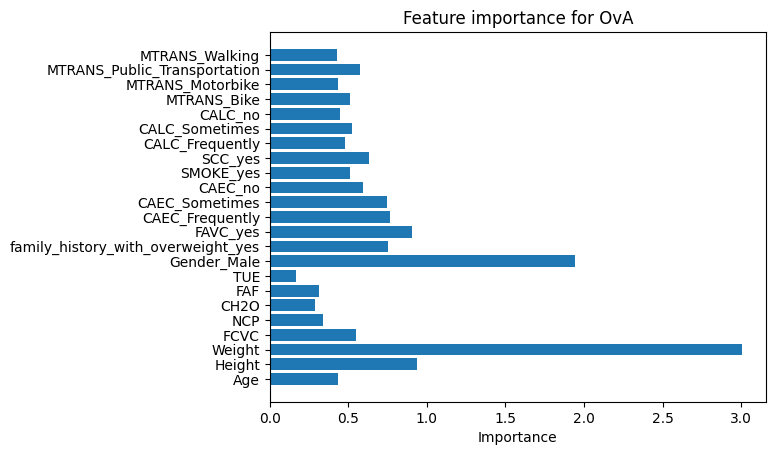

In [37]:
# Feature importance for OvA
feature_importance = np.mean(np.abs(model_ova.coef_),axis=0)
plt.barh(X.columns,feature_importance)
plt.title('Feature importance for OvA')
plt.xlabel('Importance')
plt.show()

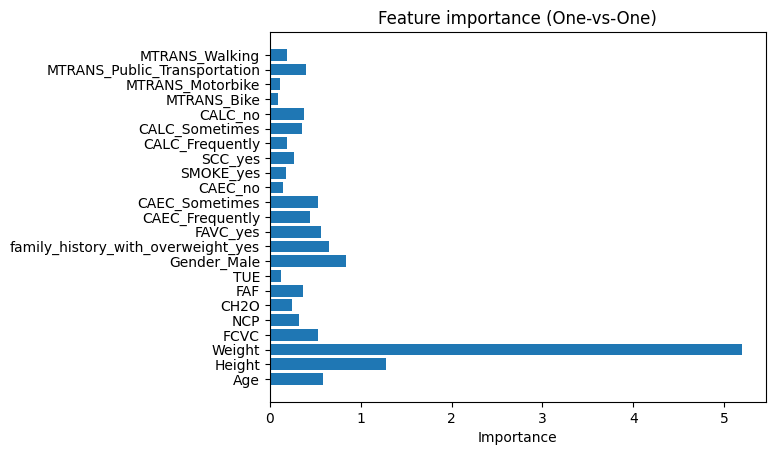

In [60]:
# Feature importance for OvO
# collect all coefficients from each underlying binary classifier
coefs = np.array([est.coef_[0] for est in model_ovo.estimators_])

# now take the mean across all those classifiers

feature_importance = np.mean(np.abs(coefs),axis=0)

# plot feature importance
plt.barh(X.columns, feature_importance)
plt.title('Feature importance (One-vs-One)')
plt.xlabel('Importance')
plt.show()


Lets write a function obesity_risk_pipeline that automates the entire pipeline:
1. Loading and preprocessing the data
2. Training the model
3. Evaluating the model

The function accepts the file path and test set size as input arguments

In [67]:
def obesity_risk_pipeline(data_path, test_size=0.2):
  df = pd.read_csv(data_path)
  num_cols = df.select_dtypes(include='float64').columns.tolist()
  scaler = StandardScaler()
  scaled_features = scaler.fit_transform(df[num_cols])
  scaled_data = pd.DataFrame(scaled_features,columns=scaler.get_feature_names_out(num_cols))
  scaled_df = pd.concat([df.drop(columns=num_cols),scaled_data],axis=1)
  cat_cols = scaled_df.select_dtypes(include=['object']).columns.tolist()
  cat_cols.remove('NObeyesdad')
  encoder = OneHotEncoder(sparse_output=False, drop='first')
  encoded_features = encoder.fit_transform(scaled_df[cat_cols])
  encoded_data = pd.DataFrame(encoded_features,columns=encoder.get_feature_names_out(cat_cols))
  prepped_df = pd.concat([scaled_df.drop(columns=cat_cols),encoded_data],axis=1)
  prepped_df['NObeyesdad'] = prepped_data['NObeyesdad'].astype('category').cat.codes
  X = prepped_df.drop('NObeyesdad',axis=1)
  y = prepped_df['NObeyesdad']
  X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size,random_state=42,stratify=y)
  model_ova = LogisticRegression(multi_class='ovr',max_iter=100)
  model_ova.fit(X_train,y_train)
  y_pred_ova = model_ova.predict(X_test)
  accuracy_ova = np.round(100*accuracy_score(y_pred_ova,y_test),2)
  model_ovo = OneVsOneClassifier(LogisticRegression(max_iter=100))
  model_ovo.fit(X_train,y_train)
  y_pred_ovo = model_ovo.predict(X_test)
  accuracy_ovo = np.round(100*accuracy_score(y_pred_ovo,y_test),2)
  return print(f"OvA accuracy: {accuracy_ova}%\nOvO accuracy: {accuracy_ovo}%")

In [68]:
obesity_risk_pipeline('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/GkDzb7bWrtvGXdPOfk6CIg/Obesity-level-prediction-dataset.csv')

OvA accuracy: 76.12%
OvO accuracy: 92.2%
